Some weights of the model checkpoint at facebook/detr-resnet-50 were not used when initializing DetrForObjectDetection: ['model.backbone.conv_encoder.model.layer1.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing DetrForObjectDetection from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DetrForObjectDetection from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


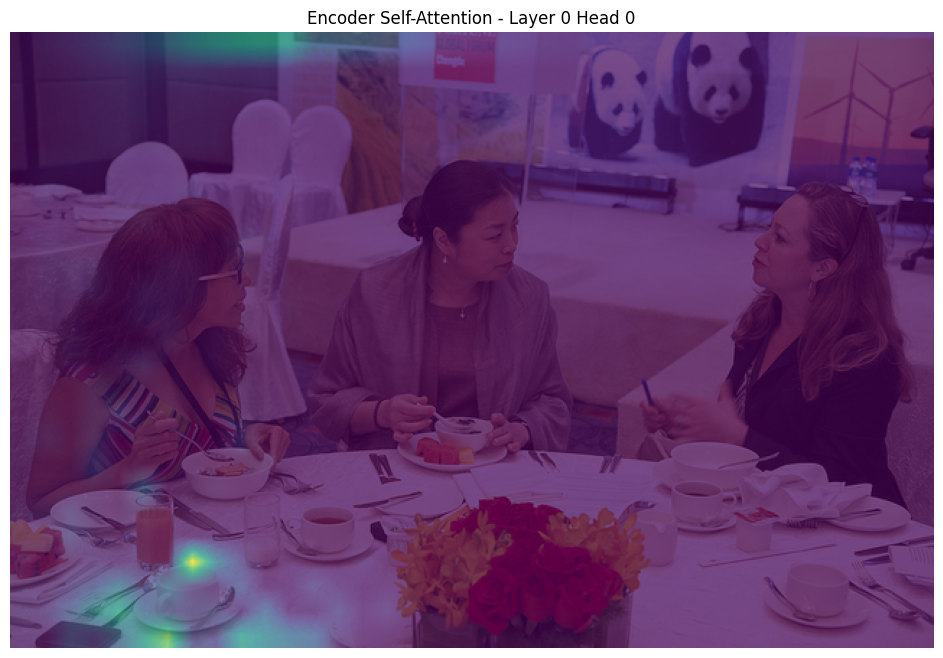

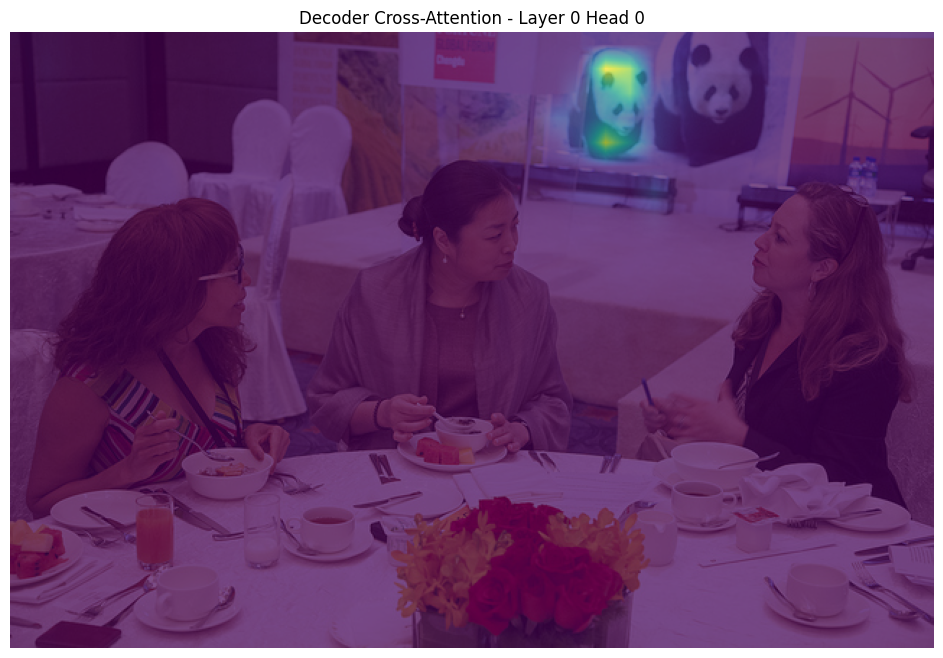

In [42]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import requests
import torch
from transformers import DetrImageProcessor, DetrForObjectDetection

# 加载预训练模型和处理器
processor = DetrImageProcessor.from_pretrained("facebook/detr-resnet-50", cache_dir = "D:/Study/facebook/")
model = DetrForObjectDetection.from_pretrained("facebook/detr-resnet-50", output_attentions=True, cache_dir = "D:/Study/facebook/")

# 下载示例图像
path = "D:/Study/coco_2017/coco2017/test2017/000000000448.jpg"
image = Image.open(path)

# 预处理图像
inputs = processor(images=image, return_tensors="pt")
outputs = model(**inputs)

# 获取注意力权重
encoder_attentions = outputs.encoder_attentions  # (层数, batch, head, H*W, H*W)
decoder_attentions = outputs.decoder_attentions  # (层数, batch, head, num_queries, H*W)
cross_attentions = outputs.cross_attentions      # (层数, batch, head, num_queries, H*W)

# 可视化工具函数
def plot_attention(image, attention_weights, title, layer=0, head=0, alpha=0.7):
    # 将注意力权重转换为热力图
    attn = attention_weights[layer].detach().numpy()
    attn = attn.mean(axis=0) if attn.ndim == 3 else attn
    
    # 调整尺寸匹配原图
    h, w = image.size[::-1]  # PIL图像尺寸为(width, height)
    attn = attn.reshape(25, -1)
    attn_resized = np.array(Image.fromarray(attn).resize((w, h), Image.BILINEAR))
    
    # 绘制叠加图
    plt.figure(figsize=(12, 8))
    plt.imshow(image)
    plt.imshow(attn_resized, cmap='viridis', alpha=alpha)
    plt.title(f"{title} - Layer {layer} Head {head}")
    plt.axis('off')
    plt.show()

# ----------------------------
# 可视化编码器自注意力（图3）
# ----------------------------
# 选择编码器最后一层（layer=5）的某个头（head=2）
encoder_layer, encoder_head = 5, 2
# 随机选择一个位置（例如中心位置）
position_idx = 850  # 假设特征图是25x34（196=14*14）
encoder_attn = encoder_attentions[encoder_layer][0, encoder_head, position_idx]

plot_attention(
    image, 
    encoder_attn.unsqueeze(0),  # 扩展维度匹配函数输入
    "Encoder Self-Attention", 
    layer=0,  # 这里传0因为已经指定了encoder_layer
    head=0
)

# ----------------------------
# 可视化解码器交叉注意力（图6）
# ----------------------------
# 选择解码器最后一层（layer=5）和某个查询（query=42）
decoder_layer, query_idx = 5, 42
# 取交叉注意力（query与编码器输出的交互）
cross_attn = cross_attentions[decoder_layer][0, :, query_idx].mean(dim=0)  # 平均所有头

plot_attention(
    image,
    cross_attn.unsqueeze(0),
    "Decoder Cross-Attention",
    layer=0,
    head=0
)

In [41]:
inputs['pixel_values'].shape

torch.Size([1, 3, 800, 1199])